# Classification. Linear models and KNN

In [491]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [635]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import chi2, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [61]:
PATH = "./data/"

In [62]:
data_train = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
data_gender = pd.read_csv(os.path.join(PATH, 'titanic', 'gender_submission.csv'))

In [98]:
data_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

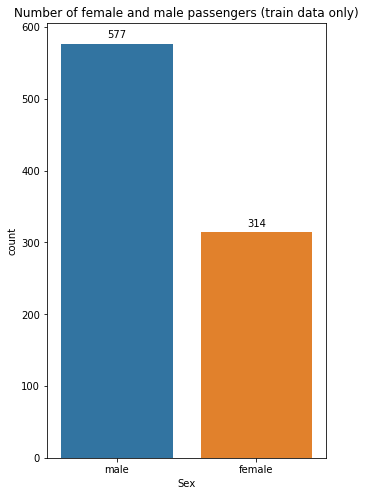

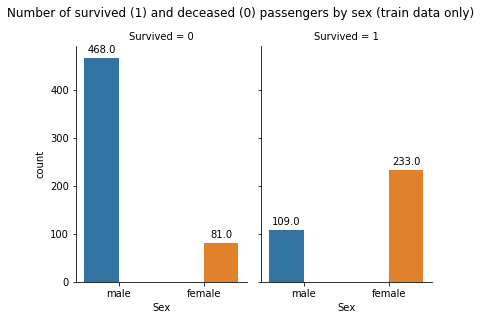

Below are the results of a chi-squared test to determine if there is any correlation between gender and survival.


The degree of freedom is: 1

The expected frequencies are:
 [[193.47474747 120.52525253]
 [355.52525253 221.47474747]]

Probability = 0.950, Critical = 3.841, Stat = 260.717
Dependent (reject the null hypothesis)

Significance = 0.050, P-value = 0.000
Dependent (reject the null hypothesis)



In [255]:
### How many females and males are there in the dataset?

# Get the data for sns and set the labels
ax = sns.countplot(x="Sex", data=data_train)
plt.xlabel("Sex")
plt.ylabel("count")
ax.set_title('Number of female and male passengers (train data only)')
# plt.title("Number of female and male passengers (train data only)")


# Show counts above each chart
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, height + 8,height ,ha="center")

# Show the plot
plt.rcParams["figure.figsize"]=(5, 8)
plt.show(ax)
      


### What about the survived passengers?

# Get the data for sns and set the labesl
ax = sns.catplot(x="Sex", hue="Sex", col="Survived",
                data=data_train, kind="count",
                height=4, aspect=.7, legend=False)

ax.fig.suptitle("Number of survived (1) and deceased (0) passengers by sex (train data only)",
                  fontsize=12, fontdict={"weight": "bold"}, y=1.05, ha='center')

# Show counts above each chart
for ax in ax.axes.ravel():
    for p in ax.patches:
        height = p.get_height()
        ax.annotate('{}'.format(height),
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show(ax)


### Is there any relationship between the gender and the survival?

# Gender and survival are two categorical variables. Hence, we could use a chi-squared test to see if there is any correlation.

stat, p, dof, expected = chi2_contingency(pd.crosstab(data_train.Sex, data_train.Survived))
print("\033[1mBelow are the results of a chi-squared test to determine if there is any correlation between gender and survival.\033[0m\n\n")
print('The degree of freedom is: %d\n' % dof)
print(f"The expected frequencies are:\n {expected}\n")

# Interpret the test statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('Probability = %.3f, Critical = %.3f, Stat = %.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject the null hypothesis)\n')
else:
    print('Independent (fail to reject the null hypothesis)\n')

# Interpret the p-value
alpha = 1.0 - prob
print('Significance = %.3f, P-value = %.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject the null hypothesis)\n')
else:
    print('Independent (fail to reject the null hypothesis)\n')

The p-value in our chi-squared test output is equal to 0.000. This means that the relationship between gender and survival is significant.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

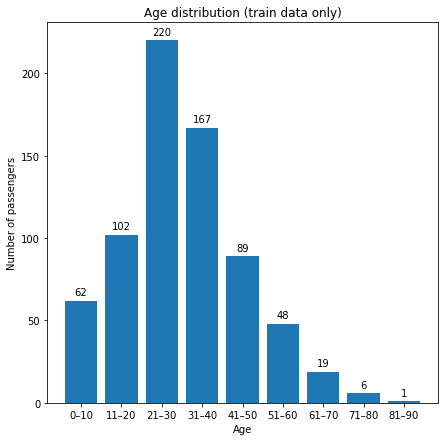

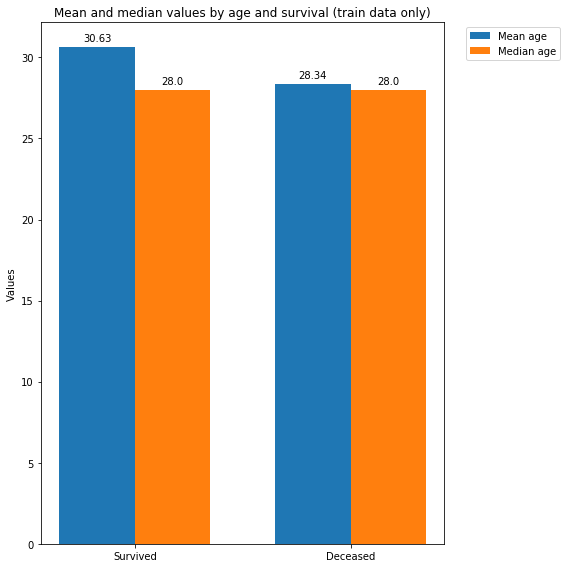

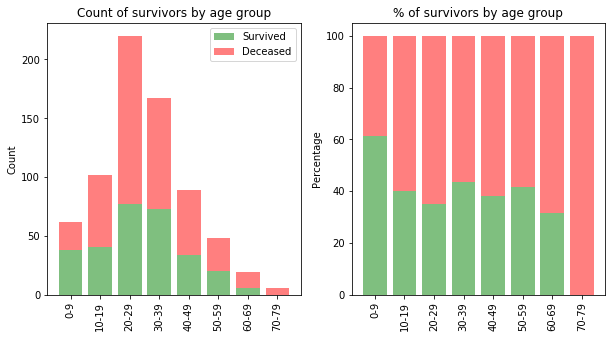

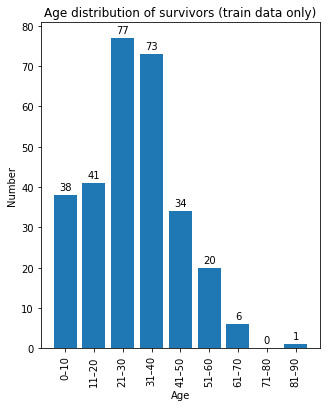

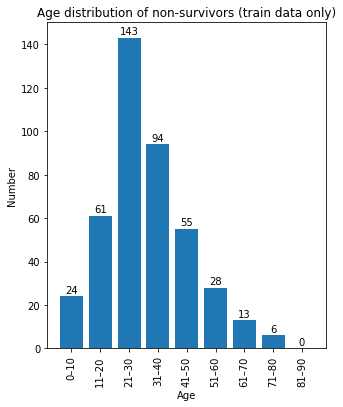

In [349]:
### Plot age distribution of the passengers.

# Get the data and set the labels
ages = data_train[data_train['Age'].notnull()]['Age'].values
ages_hist = np.histogram(ages, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ages_hist_labels = ["0–10", "11–20", "21–30", "31–40", "41–50", "51–60", "61–70", "71–80", "81–90"]

# Plot the histogram
plt.figure(figsize=(7, 7))
plt.title('Age distribution (train data only)')
plt.bar(ages_hist_labels, ages_hist[0])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
for i, bin in zip(ages_hist[0], range(9)):
    plt.text(bin, i+5, str(int(i)), fontsize=10,
             horizontalalignment='center', verticalalignment='center')
plt.show()


### What is the average and the median age of survived and deceased passengers?

age_mean = data_train[["Survived", "Age"]].groupby("Survived").mean()
age_median = data_train[["Survived", "Age"]].groupby("Survived").median()

labels = ['Survived', 'Deceased']
age_mean = [data_train[["Survived", "Age"]].groupby("Survived").mean()['Age'][0], 
            data_train[["Survived", "Age"]].groupby("Survived").mean()['Age'][1]]
age_median = [data_train[["Survived", "Age"]].groupby("Survived").median()['Age'][0], 
            data_train[["Survived", "Age"]].groupby("Survived").median()['Age'][1]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(8,8))
rects1 = ax.bar(x - width/2, age_mean, width, label='Mean age')
rects2 = ax.bar(x + width/2, age_median, width, label='Median age')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Mean and median values by age and survival (train data only)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


### Do age distributions differ for survived and deceased passengers?

# This is solution 1

def calculate_percentage(val, total, format_percent = False):
    """Calculates the percentage of a value over a total"""
    percent = np.divide(val, total, dtype=float)
    if format_percent:
        percent = as_percent(percent)
    return percent

# calculate values for each survival status
survivors_data = data_train[data_train.Survived==True]
non_survivors_data = data_train[data_train.Survived==False]

age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
data_train['age_group'] = pd.cut(data_train.Age, range(0, 81, 10), right=False, labels=age_labels)

survivors_age_group = survivors_data.groupby(['age_group']).size().values
non_survivors_age_group = non_survivors_data.groupby(['age_group']).size().values

# calculate totals for percentages
totals = survivors_age_group + non_survivors_age_group

# use calculate_percentage_function to calculate percentage of the total
data1_percentages = calculate_percentage(survivors_age_group, totals)*100 
data2_percentages = calculate_percentage(non_survivors_age_group, totals)*100 


tick_spacing = np.array(range(len(age_labels)))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# plot chart for count of survivors by age group
ax1.bar(range(len(survivors_age_group)), survivors_age_group, label='Survived', alpha=0.5, color='g')
ax1.bar(range(len(non_survivors_age_group)), non_survivors_age_group, bottom=survivors_age_group, label='Deceased', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks(tick_spacing, age_labels)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of survivors by age group", fontsize=12)
ax1.legend(loc="upper right")

# plot chart for percentage of survivors by age group
ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.5, color='g')
ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks(tick_spacing,  age_labels)
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors by age group",fontsize=12)
plt.show()


# This is solution 2

# Get the data and set the labels
ages_survivors = data_train[(data_train["Survived"] == 1) & (data_train["Age"].notnull())]['Age'].values
ages_hist = np.histogram(ages_survivors, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ages_hist_labels = ["0–10", "11–20", "21–30", "31–40", "41–50", "51–60", "61–70", "71–80", "81–90"]

# Plot the histogram
plt.figure(figsize=(5, 6))
plt.title('Age distribution of survivors (train data only)')
plt.bar(ages_hist_labels, ages_hist[0])
plt.xlabel('Age')
plt.ylabel('Number')
for i, bin in zip(ages_hist[0], range(9)):
    plt.text(bin, i+2, str(int(i)), fontsize=10,
             horizontalalignment='center', verticalalignment='center')
plt.tick_params(axis='x', rotation=90)
plt.show()

# Get the data and set the labels
ages_survivors = data_train[(data_train["Survived"] == 0) & (data_train["Age"].notnull())]['Age'].values
ages_hist = np.histogram(ages_survivors, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ages_hist_labels = ["0–10", "11–20", "21–30", "31–40", "41–50", "51–60", "61–70", "71–80", "81–90"]

# Plot the histogram
plt.figure(figsize=(5, 6))
plt.title('Age distribution of non-survivors (train data only)')
plt.bar(ages_hist_labels, ages_hist[0])
plt.xlabel('Age')
plt.ylabel('Number')
for i, bin in zip(ages_hist[0], range(9)):
    plt.text(bin, i+3, str(int(i)), fontsize=10,
             horizontalalignment='center', verticalalignment='center')
plt.tick_params(axis='x', rotation=90)
plt.show()

### Why?
The charts present an interesting picture. Most of the deceased seem to be young. This is strange given that they should be more likely to survive. On the other hand, there is a large percentage of survivors among very young and old passengers. This shows that the crew and other passengers attempted to save the most vulnerable first, even at the risk of losing their own lives.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

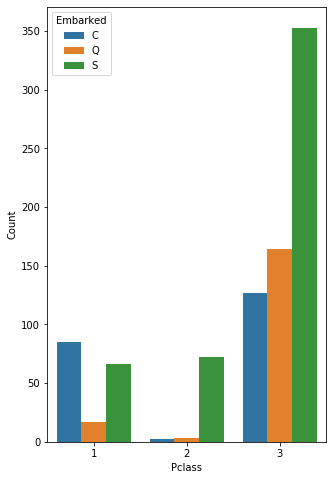

In [496]:
### Explore "passenger class" and "embarked" features.
data_for = pd.DataFrame({
    'Embarked': np.repeat(['C', 'Q', 'S'], 3),
    'Pclass': [1, 2, 3]*3,
    'Count': [85, 2, 127, 17, 3, 164, 66, 72, 353]
})

sns.barplot(x='Pclass', y='Count', hue='Embarked', data=data_for)
plt.show()

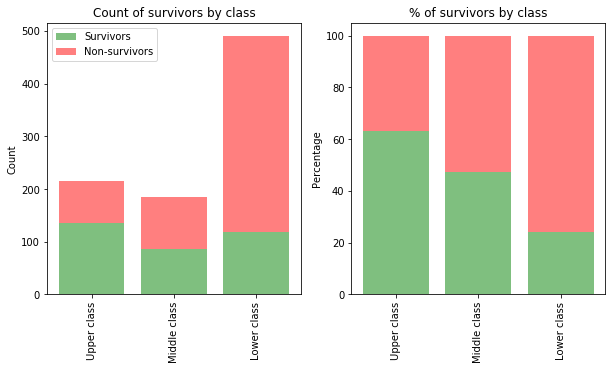

In [504]:
### What class was "the safest"?

# calculate values for each survival status
survivors_class = survivors_data.groupby(['Pclass']).size().values
non_survivors_class = non_survivors_data.groupby(['Pclass']).size().values

# calculate totals for percentates
totals = survivors_class + non_survivors_class

# use calculate_percentage_function to calculate percentage of the total
data1_percentages = calculate_percentage(survivors_class, totals)*100 
data2_percentages = calculate_percentage(non_survivors_class, totals)*100 


class_categories = ['Upper class', 'Middle class', 'Lower class']


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot chart for count of survivors by class
ax1.bar(range(len(survivors_class)), survivors_class, label='Survivors', alpha=0.5, color='g')
ax1.bar(range(len(non_survivors_class)), non_survivors_class, bottom=survivors_class, label='Non-survivors', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks([0, 1, 2], class_categories)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of survivors by class",fontsize=12)
plt.legend(loc='upper left')

# plot chart for percentage of survivors by class
ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.5, color='g')
ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks([0, 1, 2],  class_categories)
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors by class",fontsize=12)
plt.show()

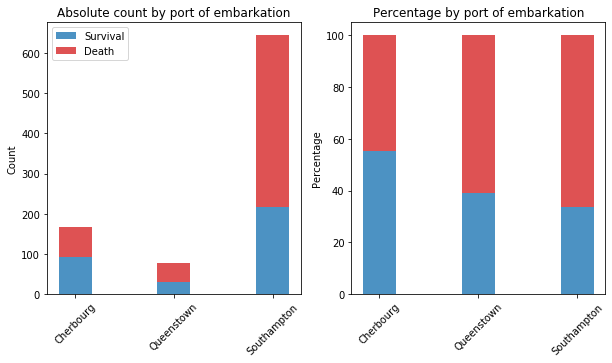

In [505]:
### Is there any relationship between the embarkation port and the survival?

total_passenger_count = len(data_train['Embarked'])
cherbourg_count = (data_train['Embarked'] == 'C').sum()
queenstown_count = (data_train['Embarked'] == 'Q').sum()
southampton_count = (data_train['Embarked'] == 'S').sum()

per_cherbourg =  cherbourg_count / total_passenger_count * 100
per_queenstown = queenstown_count / total_passenger_count * 100
per_southampton = southampton_count / total_passenger_count * 100


def get_counts(dataframe, factor, quality, status):
    '''
    dataframe - the dataframe on which to apply the function (e.g. 'df' for the Titanic dataframe)
    factor - the column on which to perform the analysis (e.g. 'Pclass' for the ticket class)
    quality - the quality on which to perform the analysis (e.g '3' for the third class)
    status - the status you want to count: survival or death. Should be a Boolean (1 for survival, 0 for death).
    '''
    target = dataframe[factor].where(dataframe[factor] == quality)
    class_count = target.where(dataframe['Survived'] == status).count()
    return class_count

cherbourg_survival_count = get_counts(data_train, 'Embarked', 'C', 1)
queenstown_survival_count = get_counts(data_train, 'Embarked', 'Q', 1)
southampton_survival_count = get_counts(data_train, 'Embarked', 'S', 1)
cherbourg_death_count = get_counts(data_train, 'Embarked', 'C', 0)
queenstown_death_count = get_counts(data_train, 'Embarked', 'Q', 0)
southampton_death_count = get_counts(data_train, 'Embarked', 'S', 0)


def gen_plot(survival_array, death_array, by_factor, x_ticks):
    """
    survival_array: a list providing the survival data being analyzed (eg. [class1_survival_count, class2_survival_count, class3_survival_count])
    death_array: a list providing the death data being analyzed (eg. [class1_death_count, class2_death_count, class3_death_count])
    by_title: the factor that is the focus of the analysis (eg. 'by ticket class')
    x_ticks: (eg. ['First class', 'Second class', 'Third class'])
    """
    
    abs_survival_list = np.array(survival_array)
    abs_death_list = np.array(death_array)
    N = len(abs_survival_list)
    ind = np.arange(N)
    width = 1 / N

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))


    # Absolute count
    ax1.bar(ind, abs_survival_list, width, label='Survival', alpha=0.8)
    ax1.bar(ind, abs_death_list, width, color='#d62728', label='Death', alpha=0.8, bottom=abs_survival_list)

    plt.sca(ax1)
    plt.xticks(ind, x_ticks)

    ax1.set_title('Absolute count ' + by_factor)
    ax1.set_ylabel('Count')
    ax1.legend(loc='upper left')

    plt.setp(plt.gca().get_xticklabels(), rotation=45)


    # Percentage
    per_survival_list = (abs_survival_list / (abs_survival_list + abs_death_list)) * 100
    per_death_list = (abs_death_list / (abs_survival_list + abs_death_list)) * 100

    ax2.bar(ind, per_survival_list, width, label='Survival percentage', alpha=0.8)
    ax2.bar(ind, per_death_list, width, color='#d62728', label='Death percentage', alpha=0.8, bottom=per_survival_list)

    plt.sca(ax2)
    plt.xticks(ind, x_ticks)

    ax2.set_title('Percentage ' + by_factor)
    ax2.set_ylabel('Percentage')

    plt.setp(plt.gca().get_xticklabels(), rotation=45)

    return plt.show()

gen_plot([cherbourg_survival_count, queenstown_survival_count, southampton_survival_count],
         [cherbourg_death_count, queenstown_death_count, southampton_death_count],
         'by port of embarkation',
         ['Cherbourg', 'Queenstown', 'Southampton'])

The charts show two interesting things. First, there is a strong correlation between survival and class. Second, there is also an interesting correlation between the port of embarkation and survival. It might be down to the fact that most of the passengers from Cherbourg had first-class tickets.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [506]:
pd.DataFrame(data_train.isnull().mean() * 100).rename(columns={0: "Percentage of missing values"}).T

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_group
Percentage of missing values,0.0,0.0,0.0,0.0,19.86532,0.0,0.0,0.0,0.0,77.104377,0.224467,19.977553


### Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

The are a number of limitations which are caused by missing values. The missing values and the size of the sample could skew the results. We could do one of the following to handle missing values:

#### Ignore the missing values

If the percentage of missing values is under 10% for an individual case or observation, we can generally ignore this. The negative effect of this is minimal.

#### Drop the missing values

In this case, we lose some potentially valuable information, but again the effect will not be dramatic.

#### Drop a variable

If the number of missing values for a feature is very high, then that feature should be left out of the analysis. It is also advisable to delete the dependent variable(s) to avoid any artificial increase in relationships with independent variables.

#### Case deletion

In this method, cases which have missing values for one or more features are deleted. If the cases having missing values are small in number, it is better to drop them. Though this is an easy approach, it might lead to a significant decrease in the sample size. Also, the data may not always be missing completely at random. This may lead to biased estimation of parameters.

#### Imputation

Imputation is the process of substituting the missing data by some statistical methods. Imputation is useful in the sense that it preserves all cases by replacing missing data with an estimated value based on other available information. But imputation methods should be used carefully as most of them introduce a large amount of bias and reduce variance in the dataset.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [510]:
# y = data_train['Survived']
# test_df = pd.read_csv("test.csv")
# train_df = pd.read_csv("train.csv")

In [688]:
train_df = data_train
test_df = data_test

### Relatives

data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

### Cabin:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)


### Age:

data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

### Embarked:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)
    
### Fare:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

### Name:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

### Sex:

genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)
    
### Ticket:

train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

### Embarked:
ports = {"C": 1, "Q": 2, "S": 3}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)
    

    
### Categories ###

### Age:

data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(float)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed train_df['Age'].value_counts()

### Fare:

data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

### 1. Age times Class
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']
    
### 2. Fare per Person

for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.



### Data for training
Y_train = train_df["Survived"]
X_train = train_df.drop(["Survived", "age_group"], axis=1)
X_test  = test_df.drop(["PassengerId"], axis=1)
X_test.fillna(0, inplace=True)


### Logistic regression model
logreg = LogisticRegression(max_iter=50000)
logreg.fit(X_train, Y_train)

Y_pred_logreg = logreg.predict(X_test)

acc_logreg = round(logreg.score(X_train, Y_train) * 100, 2)

### KNN model

knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred_knn = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)


print(f"This is the accuracy score for the logreg model: {acc_log}\n")
print(f"This is the accuracy score for the knn model: {acc_knn}\n")

This is the accuracy score for the logreg model: 81.71

This is the accuracy score for the knn model: 86.42



In [636]:
### Cross validation

from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.78888889 0.83146067 0.73033708 0.85393258 0.85393258 0.83146067
 0.82022472 0.7752809  0.87640449 0.83146067]
Mean: 0.8193383270911362
Standard Deviation: 0.04108668858185371


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## Hyperparameter tuning (this should not be run as it may take a very long time.)

# param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
# from sklearn.model_selection import GridSearchCV, cross_val_score
# rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
# clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
# clf.fit(X_train, Y_train)
# clf.bestparams

# # Random Forest
# random_forest = RandomForestClassifier(criterion = "gini", 
#                                        min_samples_leaf = 1, 
#                                        min_samples_split = 10,   
#                                        n_estimators=100, 
#                                        max_features='auto', 
#                                        oob_score=True, 
#                                        random_state=1, 
#                                        n_jobs=-1)

# random_forest.fit(X_train, Y_train)
# Y_prediction = random_forest.predict(X_test)

# random_forest.score(X_train, Y_train)

# print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

In [699]:
Y_train = train_df["Survived"]
X_train = train_df.drop(["Survived", "age_group"], axis=1)
X_test  = test_df.drop(["PassengerId"], axis=1)
X_test.fillna(0, inplace=True)





,Age,Sex,Pclass,Embarked,SibSp
0,0.0,0,3,2,0
1,2.0,1,3,3,1
2,5.0,0,2,2,0
3,3.0,0,3,3,0
4,5.0,1,3,3,1


In [705]:
### Data for training
Y_train = train_df["Survived"]
X_train = train_df.drop(["Survived", "age_group"], axis=1)
X_test  = test_df.drop(["PassengerId"], axis=1)
X_test.fillna(0, inplace=True)

# X_train = X_train[["Age", "Sex", "Pclass", "SibSp"]]
# X_test = X_test[["Age", "Sex", "Pclass", "SibSp"]]

categorical_features = list(X_train)
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_log = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])

pipeline_log = Pipeline(steps=[('preprocessor', preprocessor_log),
                           ('classifier', LogisticRegression(max_iter=50000))])

clf_log_reg = pipeline_log.fit(X_train, Y_train)

log_reg_score = accuracy_score(y_true=Y_train, y_pred=clf_log_reg.predict(X_train))



categorical_features = list(X_train)
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_knn = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])

pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor_knn),
                           ('classifier', KNeighborsClassifier(n_neighbors = 3))])

clf_knn = pipeline_knn.fit(X_train, Y_train)

knn_score = accuracy_score(y_true=Y_train, y_pred=clf_knn.predict(X_train))

y_pred_log = clf_log_reg.predict(X_test)
y_pred_knn = clf_knn.predict(X_test)

print(knn_score, log_reg_score)

0.8787878787878788 0.856341189674523


In [706]:
## Submission to Kaggle 1


#Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
submission = pd.DataFrame({'PassengerId':data_test['PassengerId'],'Survived':y_pred_log})

#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'Titanic Predictions_Logreg_2.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)


#Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
submission = pd.DataFrame({'PassengerId':data_test['PassengerId'],'Survived':y_pred_knn})

#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'Titanic Predictions_KNN_2.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)



Saved file: Titanic Predictions_Logreg_2.csv
Saved file: Titanic Predictions_KNN_2.csv
My Kaggle score is: 0.76076


### My username on Kaggle: Mutalibbek
#### My Kaggle score: 0.76076

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [692]:
## Submission to Kaggle 2


# #Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
# submission = pd.DataFrame({'PassengerId':data_test['PassengerId'],'Survived':Y_pred_logreg})

# #Convert DataFrame to a csv file that can be uploaded
# #This is saved in the same directory as your notebook
# filename = 'Titanic Predictions_Logreg_1.csv'

# submission.to_csv(filename,index=False)

# print('Saved file: ' + filename)

# #Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
# submission = pd.DataFrame({'PassengerId':data_test['PassengerId'],'Survived':Y_pred_knn})

# #Convert DataFrame to a csv file that can be uploaded
# #This is saved in the same directory as your notebook
# filename = 'Titanic Predictions_KNN_1.csv'

# submission.to_csv(filename,index=False)

# print('Saved file: ' + filename)

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [660]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [661]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [708]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [709]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [710]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [711]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [712]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

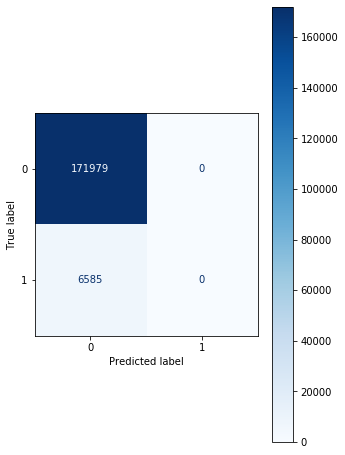

In [713]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [716]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

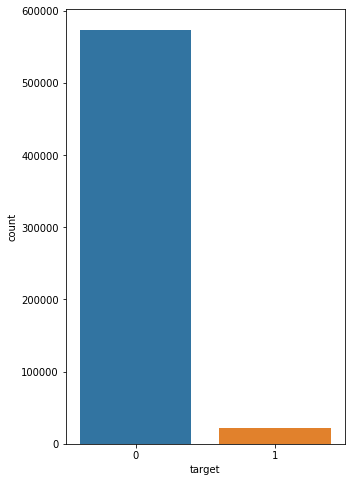

In [717]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [718]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code